<a href="https://colab.research.google.com/github/saikrishna1108/5106_Final_Project/blob/main/Transformers/Transformer_Regression_seq_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import os
import torch
import numpy as np
import pandas as pd
import random
from torch.utils.data import DataLoader, Dataset
import math

class SpeedDataset(Dataset):
    def __init__(self, directory, sequence_length=5, augment=False, overlap=1):
        self.data = []
        self.sequence_length = sequence_length
        self.augment = augment  # Enable or disable augmentation
        self.overlap = overlap  # Control the overlap between sequences
        self.preprocess_data(directory)

    def preprocess_data(self, directory):
        for filename in os.listdir(directory):
            if filename.endswith('.csv'):
                filepath = os.path.join(directory, filename)
                df = pd.read_csv(filepath)
                df.sort_values(by=['id', 'frame'], inplace=True)  # Sort by track ID and frame number
                
                track_data = df.groupby('id')
                
                for track_id, group in track_data:
                    group = group.reset_index(drop=True)  # Reset index after sorting
                    for i in range(0, len(group) - self.sequence_length + 1, self.overlap):
                        # Check if the frames within the window are consecutive
                        if group['frame'].iloc[i:i + self.sequence_length].diff().dropna().eq(1).all():
                            frames = group.iloc[i:i + self.sequence_length]
                            features = self.extract_features(frames[['x_tl_2d', 'y_tl_2d', 'x_br_2d', 'y_br_2d']].values)
                            speed = frames['average_speed_5_frames'].mean()  # Calculate the average speed for the sequence
                            self.data.append((features, speed))

    def extract_features(self, frames):
        features = []
        for i in range(1, len(frames)):
            current_frame = frames[i]
            previous_frame = frames[i-1]
            features.append(self.compute_frame_features(current_frame, previous_frame))
        return features

    def compute_frame_features(self, current_frame, previous_frame):
        x1, y1, x2, y2 = current_frame
        px1, py1, px2, py2 = previous_frame
        
        x1_change = abs(x1 - px1)
        y1_change = abs(y1 - py1)
        x2_change = abs(x2 - px2)
        y2_change = abs(y2 - py2)

        center_x_change = abs((x1 + x2)/2 - (px1 + px2)/2)
        center_y_change = abs((y1 + y2)/2 - (py1 + py2)/2)
        distance_moved1 = math.sqrt(center_x_change ** 2 + center_y_change ** 2)
        distance_moved2 = math.sqrt(x1_change ** 2 + y1_change ** 2)
        distance_moved3 = math.sqrt(x2_change ** 2 + y2_change ** 2)

        feature_vector = [distance_moved1, distance_moved2, distance_moved3, center_x_change, center_y_change, x1_change, y1_change, x2_change, y2_change]
        return feature_vector

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        inputs, output = self.data[idx]
        if self.augment:
            inputs = self.apply_augmentation(inputs)
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(output, dtype=torch.float32)

    def apply_augmentation(self, inputs):
        if random.random() > 0.6:
            inputs = self.add_noise(inputs)
        if random.random() > 0.99:
            inputs = self.time_shift(inputs, shift=random.choice([-1, 1]))
        if random.random() > 0.8:
            inputs = self.scale_features(inputs, scale=random.uniform(0.9, 1.1))
        if random.random() > 0.99:
            inputs = self.mirror_features(inputs)
        return inputs

    def add_noise(self, features, noise_level=0.05):
        noise = np.random.normal(0, noise_level, features.shape)
        return features + noise

    def time_shift(self, features, shift=1):
        if shift > 0:
            return np.vstack([np.zeros((shift, features.shape[1])), features[:-shift]])
        elif shift < 0:
            return np.vstack([features[-shift:], np.zeros((-shift, features.shape[1]))])
        return features

    def scale_features(self, features, scale=1.1):
        return features * scale

    def mirror_features(self, features):
        features_copy = features.copy()
        features_copy[:, [0, 2]] = -features_copy[:, [0, 2]]  # Assume these indices are the x-coordinates
        return features_copy


In [29]:
import torch

# Check for CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class SpeedPredictor(nn.Module):
    def __init__(self, sequence_length, feature_size, hidden_dim, output_size):
        super(SpeedPredictor, self).__init__()
        self.embedding = nn.Conv1d(in_channels=feature_size, out_channels=hidden_dim, kernel_size=1)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, dim_feedforward=hidden_dim * 4, dropout=0.2)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=5)
        self.fc1 = nn.Linear(hidden_dim, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(16, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = x.permute(1, 0, 2)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  
        x = x[:, -1, :]  
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.constant_(m.bias, 0)


In [31]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer,scheduler, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs+1):
        # Training
        model.train()
        total_train_loss = 0
        for inputs, speeds in train_loader:
            inputs, speeds = inputs.to(device), speeds.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs.squeeze()
            if outputs.shape != speeds.shape:
                outputs = outputs[:speeds.size(0)]
            loss = criterion(outputs, speeds)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        scheduler.step()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for inputs, speeds in val_loader:
                inputs, speeds= inputs.to(device), speeds.to(device)
                outputs = model(inputs)
                outputs = outputs.squeeze()

                if outputs.shape != speeds.shape:
                    outputs = outputs[:speeds.size(0)]
                loss = torch.sqrt(criterion(outputs, speeds))
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        if epoch % 10 ==0:
            print(f'Epoch {epoch}/{epochs}, MSE training Loss: {avg_train_loss:.4f}, RMSE validation Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses


In [35]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

train_dataset = SpeedDataset('../train', sequence_length=10, overlap = 5, augment =False)
test_dataset = SpeedDataset('../val', sequence_length=10, overlap = 5)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
len(train_dataset)

25978

In [36]:
len(test_loader)

66

In [38]:
# Model, Loss, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeedPredictor(sequence_length=10, feature_size=9, hidden_dim=128, output_size=1)
model.to(device)
model.apply(init_weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Scheduler for learning rate adjustment
scheduler = ExponentialLR(optimizer, gamma=0.999)
train_losses,val_losses = train_and_validate(model, train_loader, test_loader, criterion, optimizer, scheduler, epochs=200)

Epoch 0/200, MSE training Loss: 921.2248, RMSE validation Loss: 20.2230
Epoch 10/200, MSE training Loss: 397.8279, RMSE validation Loss: 13.5060
Epoch 20/200, MSE training Loss: 262.5167, RMSE validation Loss: 9.6658
Epoch 30/200, MSE training Loss: 230.2749, RMSE validation Loss: 8.4591
Epoch 40/200, MSE training Loss: 222.1796, RMSE validation Loss: 8.2018
Epoch 50/200, MSE training Loss: 208.0070, RMSE validation Loss: 8.0098
Epoch 60/200, MSE training Loss: 210.6259, RMSE validation Loss: 8.0563
Epoch 70/200, MSE training Loss: 205.4617, RMSE validation Loss: 8.0195
Epoch 80/200, MSE training Loss: 195.9512, RMSE validation Loss: 8.1249
Epoch 90/200, MSE training Loss: 197.6070, RMSE validation Loss: 7.9481
Epoch 100/200, MSE training Loss: 194.9541, RMSE validation Loss: 8.0821
Epoch 110/200, MSE training Loss: 191.6843, RMSE validation Loss: 8.0244
Epoch 120/200, MSE training Loss: 188.5600, RMSE validation Loss: 7.9766
Epoch 130/200, MSE training Loss: 188.4841, RMSE validation 

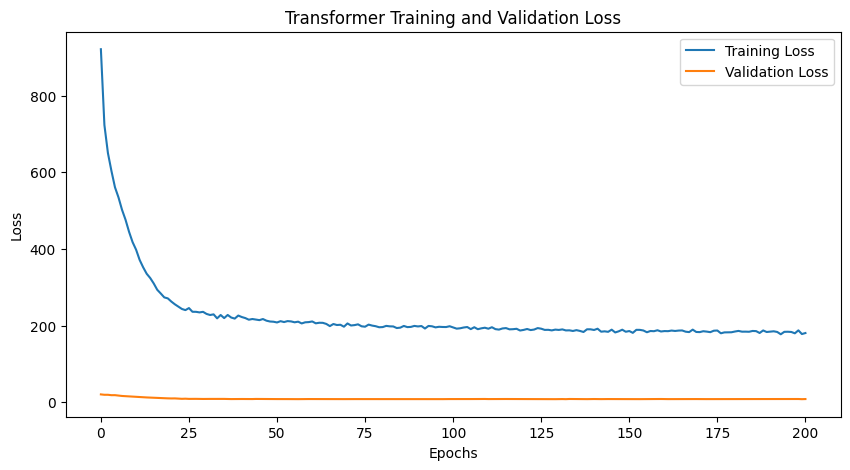

In [39]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(0, 200+1), train_losses, label='Training Loss')
plt.plot(range(0, 200+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Transformer Training and Validation Loss')
plt.legend()
plt.show()

In [40]:

torch.save(model, 'Transformer_Regressioni24_35_seq.pth')


In [41]:
# Load the entire model
import os
import torch
import numpy as np
import random
from torch.utils.data import DataLoader, Dataset
import math
model = torch.load('Transformer_Regressioni24_35_seq.pth').to(device)
model.eval()  # Set the model to evaluation mode

SpeedPredictor(
  (embedding): Conv1d(9, 128, kernel_size=(1,), stride=(1,))
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=512, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=512, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=T

In [42]:
import torch
from torch.utils.data import DataLoader
import random

def predict_and_compare(model, test_loader, criterion, device):
    model.eval()  # Ensure the model is in evaluation mode
    predictions = []
    actuals = []
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.view_as(targets)  # Ensure outputs and targets have the same shape
            loss = torch.sqrt(criterion(outputs, targets))
            total_loss += loss.item()

            predictions.extend(outputs.squeeze().tolist())
            actuals.extend(targets.tolist())

    return predictions, actuals, total_loss / len(test_loader)

def calculate_accuracy(predictions, actuals):
    accuracies = []
    for pred, actual in zip(predictions, actuals):
        if actual != 0:
            accuracy = (1 - abs(pred - actual) / abs(actual)) * 100
        else:
            accuracy = 0  # Decide how to handle actual == 0; perhaps continue or set a default accuracy value
        accuracies.append(accuracy)
    return sum(accuracies) / len(accuracies) if accuracies else 0



def print_random_predictions(predictions, actuals, num_samples=30):
    if len(predictions) < num_samples:
        num_samples = len(predictions)  # Adjust sample size if predictions are fewer than requested

    # Get random sample indices
    sample_indices = random.sample(range(len(predictions)), num_samples)

    # Print the randomly selected predictions and their actual values
    for idx in sample_indices:
        print(f"Predicted: {predictions[idx]:.4f}, Actual: {actuals[idx]:.4f}")



test_dataset = SpeedDataset('../test', sequence_length=10, overlap = 5)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
predictions, actuals, loss = predict_and_compare(model, test_loader, criterion, device)

# Calculate and print accuracy
accuracy = calculate_accuracy(predictions, actuals)
print(f"Average Accuracy: {accuracy:.2f}%")
print(f"Final RMSE Loss: {loss:.4f}")
print_random_predictions(predictions, actuals, 10)

Average Accuracy: 74.36%
Final RMSE Loss: 12.8716
Predicted: 26.8038, Actual: 24.1377
Predicted: 14.1653, Actual: 14.6732
Predicted: 72.8490, Actual: 73.3019
Predicted: 71.9722, Actual: 78.3401
Predicted: 58.9801, Actual: 84.9540
Predicted: 67.5383, Actual: 59.9927
Predicted: 17.1079, Actual: 25.2126
Predicted: 72.1246, Actual: 81.1948
Predicted: 23.9258, Actual: 70.9646
Predicted: 15.5027, Actual: 19.2875


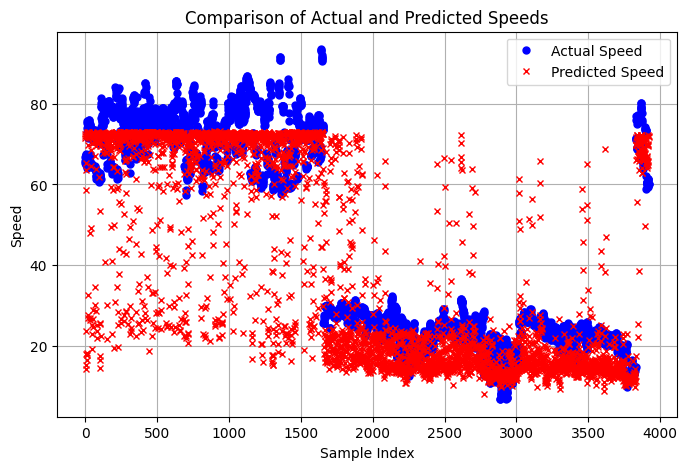

In [43]:
# Creating a plot with both predictions and actuals
plt.figure(figsize=(8, 5))

# Plotting actual speeds
plt.plot(actuals, label='Actual Speed', color='blue', marker='o', linestyle='', markersize=5)

# Plotting predicted speeds
plt.plot(predictions, label='Predicted Speed', color='red', marker='x', linestyle='', markersize=5)

plt.title('Comparison of Actual and Predicted Speeds')
plt.xlabel('Sample Index')
plt.ylabel('Speed')
plt.legend()
plt.grid(True)
plt.show()


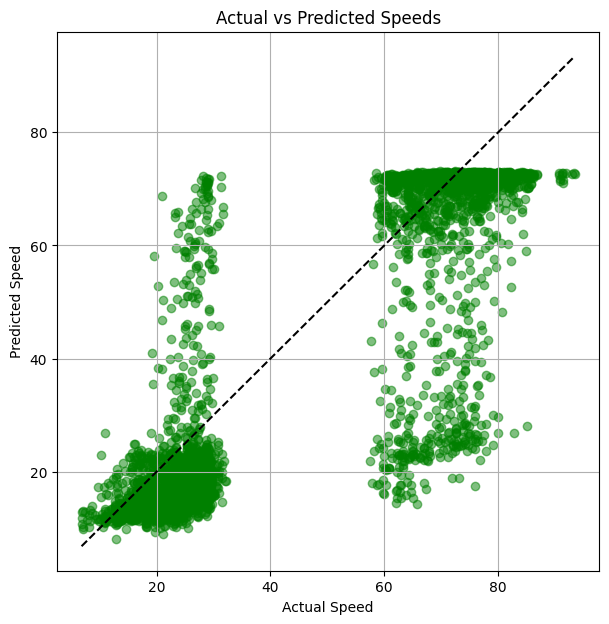

In [44]:
plt.figure(figsize=(7, 7))
plt.scatter(actuals, predictions, color='green', alpha=0.5)  # Adjust transparency with alpha
plt.title('Actual vs Predicted Speeds')
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.grid(True)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')  # Diagonal line for reference
plt.show()
